In [1]:
import pylab as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})

from numpy.random import multivariate_normal as mvn
%matplotlib inline

# Examples I

In [2]:
# Imports
import numpy as np
import swordfish as sf
from copy import deepcopy

 
# Basic grid
x = np.linspace(1, 10, 100)
dx = x[1]-x[0]

# Signal components
S1 = 3.0*np.exp(-(x-5)**2/2.)*dx
S2 = 2.0*np.exp(-(x-6)**2/2.)*dx

# Background components
B1 = 8./x*dx
B2 = 0.3*x*dx

# Background covariance matrix
X, Y = np.meshgrid(x,x)
K = (np.exp(-(X-Y)**2/20.)*0.02**2
    +np.exp(-(X-Y)**2*10.)*0.01**2)

# Exposure
E = np.ones_like(x)

# Instantiate Fishpy
SF = sf.Swordfish([B1, B2], T=[0.1, 0.0], E=E, K=K)

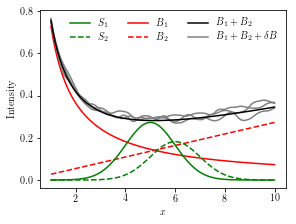

In [3]:
# Plot components
plt.figure(figsize=(4,3))
plt.plot(x, S1, 'g', label="$S_1$", zorder=100)
plt.plot(x, S2, 'g--', label="$S_2$", zorder=100)
plt.plot(x, B1, 'r', label="$B_1$")
plt.plot(x, B2, 'r--', label="$B_2$")
plt.plot(x, B1+B2, 'k', label="$B_1+B_2$", zorder=100)
for i in range(3):
    deltaB = mvn(np.zeros_like(x), K)
    label = r"$B_1+B_2+\delta B$" if i == 0 else None
    plt.plot(x, B1+B2+deltaB, '0.5', label=label)
plt.legend(ncol=3, frameon=False)
plt.xlabel("$x$")
plt.ylabel(r"$\rm Intensity$")
plt.tight_layout(pad=0.3)
plt.savefig("intensity.eps")

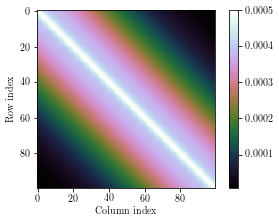

In [4]:
# Covariance matrix
plt.figure(figsize=(4,3))
plt.imshow(K, cmap='cubehelix')
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout(pad=0.3)
plt.colorbar()
plt.savefig("K.eps", dpi=200)

In [5]:
print SF.variance(S1)
print SF.variance(S2)

0.211143850642
0.474194075368


In [6]:
print SF.covariance([S1,S2])

[[ 0.5175031  -0.59670658]
 [-0.59670658  1.16222616]]


In [7]:
print SF.fishermatrix([S1,S2])

[[ 4.73610762  2.4315978 ]
 [ 2.4315978   2.10884119]]


In [8]:
SF1 = SF.infoflux(S1)
print SF1[[0, 1, 2, -1]]

[  9.73189591e-04   9.16650647e-04   8.68625323e-04   7.20402877e-05]


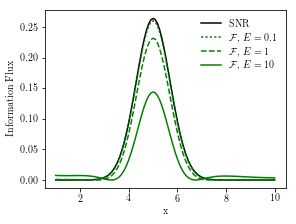

In [9]:
# Show info flux
plt.figure(figsize=(4,3))
for s, l, c in zip(
    [1e-100, 0.1, 1, 10], 
    ["SNR", "$\mathcal{F}$, $E=0.1$", "$\mathcal{F}$, $E=1$", "$\mathcal{F}$, $E=10$"],
    ['k', 'g:', 'g--', 'g']):
    SF0 = sf.Swordfish([B1, B2], T=[0.1, 0.1],
                E=E*s, K=K)
    SF1 = SF0.infoflux(S1)
    plt.plot(x, SF1, c, label=l)
plt.xlabel("x")
plt.legend(frameon=False)
plt.ylabel("Information Flux")
plt.tight_layout(pad=0.3)
plt.savefig("F.eps", dpi=200)

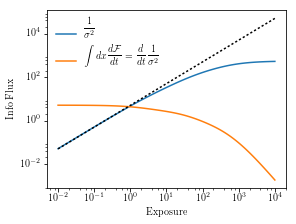

In [10]:
# Another plot
plt.figure(figsize=(4,3))

SFsum = []
varlist = []
slist = np.logspace(-2, 4, 100)
for s in slist:
    SF0 = sf.Swordfish([B1, B2], T=[0.1, 0.1],
                E=E*s, K=K)
    varlist.append(1./SF0.variance(S1))
    SFsum.append(SF0.infoflux(S1).sum())
plt.loglog(slist, varlist, label=r"$\displaystyle\frac{1}{\sigma^2}$")
plt.loglog(slist, SFsum, label=r"$\displaystyle\int dx\frac{d\mathcal{F}}{dt}=\frac{d}{dt}\frac{1}{\sigma^2}$")
plt.loglog(slist, 5.*slist, 'k:')
plt.xlabel("Exposure")
plt.legend(frameon=False)
plt.ylabel("Info Flux")
plt.tight_layout(pad=0.3)
plt.savefig("Fint.eps", dpi=200)

In [11]:
s, b = SF.equivalentcounts(S1)
print s, b

6.5838145069 9.15237087851


In [12]:
s, b = SF.totalcounts(S1)
print s, b

7.51968795145 33.8261307542


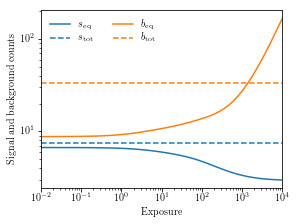

In [13]:
# Another plot
plt.figure(figsize=(4,3))

Slist = []
Blist = []
slist = np.logspace(-2, 4, 100)
for s in slist:
    SF0 = sf.Swordfish([B1, B2], T=[0.1, 0.1],
                E=E*s, K=K)
    s, b = SF0.equivalentcounts(S1)
    Slist.append(s)
    Blist.append(b)
plt.loglog(slist, Slist/slist, label=r"$s_{\rm eq}$")
s, b = SF.totalcounts(S1)
plt.plot(slist, np.ones_like(slist)*s, color='C0', ls='--', label=r'$s_{\rm tot}$')
plt.loglog(slist, Blist/slist, label=r"$b_{\rm eq}$")
plt.plot(slist, np.ones_like(slist)*b, color='C1', ls='--', label=r'$b_{\rm tot}$')
plt.xlabel("Exposure")
plt.ylabel("Signal and background counts")
plt.legend(frameon=False, ncol=2)
plt.xlim([1e-2, 1e4])
plt.tight_layout(pad=0.3)
plt.savefig("se.eps")

In [14]:
dr = SF.discoveryreach(S1, alpha = 2.87e-07)
print dr

2.85104264141


In [15]:
print SF.significance(S1*dr)

2.87003191571e-07


In [16]:
ul = SF.upperlimit(S1, alpha = 0.05)
print ul

0.98878997557


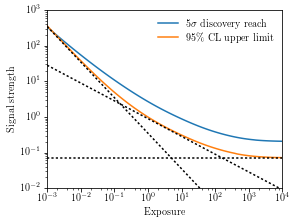

In [23]:
# Another plot
plt.figure(figsize=(4,3))

Dlist = []
Llist = []
slist = np.logspace(-3, 4, 100)
for s in slist:
    SF0 = sf.Swordfish([B1, B2], T=[0.1, 0.1],
                E=E*s, K=K)
    Dlist.append(SF0.discoveryreach(S1, 1e-6))
    Llist.append(SF0.upperlimit(S1, 0.05))
plt.loglog(slist, Dlist, label="$5\sigma$ discovery reach")
plt.loglog(slist, Llist, label="$95\%$ CL upper limit")
plt.loglog(slist, 0.35*slist**-1, 'k:')
plt.loglog(slist, 0.9*slist**-0.5, 'k:')
plt.loglog(slist, 0.07*slist**-0.0, 'k:')
plt.ylim([1e-2, 1e3])
plt.xlabel("Exposure")
plt.ylabel("Signal strength")
plt.legend(frameon=False)
plt.xlim([1e-3, 1e4])
plt.tight_layout(pad=0.3)
plt.savefig("lim.eps", dpi=200)

In [24]:
# Euclideanized signal
x1 = SF.euclideanizedsignal(S1)
x2 = SF.euclideanizedsignal(S2)
TS = (( x1 - x2 )**2).sum()
#TS = SF.Delta(S1, S2, use_lnL = False)
#TS = SF.Delta(S1, S2, use_lnL = True)
print TS
# This is the same as :
# TS = SF

1.20237082972
